In [2]:
import pickle
import numpy as np
import random
from PIL import Image
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from tqdm import tqdm

2025-12-17 12:24:35.265095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.keras.mixed_precision.set_global_policy('mixed_float16')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, running on CPU!")
    
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

1 Physical GPUs, 1 Logical GPUs
TensorFlow version: 2.20.0
Built with CUDA: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available: 1


I0000 00:00:1765945482.249741     774 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4082 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5


In [4]:
# Show CUDA version
print("CUDA Version:", tf.sysconfig.get_build_info()['cuda_version'])
print("cuDNN Version:", tf.sysconfig.get_build_info()['cudnn_version'])

CUDA Version: 12.5.1
cuDNN Version: 9


In [5]:
# Load Data
with open('../Data/processed_train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
    
with open('../Data/processed_test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [6]:
def prepare_data(data):
    x=[]
    y=[]
    label_map={}
    
    for i, class_name in enumerate(data.keys()):
        label_map[class_name] = i

        for image in data[class_name]:
            try:
                with Image.open(image) as img:
                    img_array = np.array(img)
                    x.append(img_array)
                    y.append(label_map[class_name])
            except Exception as e:
                print(f"Error loading image {image}: {e}")
                continue


    x = np.array(x)
    y = np.array(y)

    return x, y, label_map
    

x_train, y_train, label_map_train = prepare_data(train_data)
x_test, y_test, label_map_test = prepare_data(test_data)

print(x_train.shape)
print(y_train.shape)
print(label_map_train)

print(x_test.shape)
print(y_test.shape)
print(label_map_test)

print(x_train[0])
print(y_train[0])

print(x_test[0])
print(y_test[0])

(24499, 84, 84, 3)
(24499,)
{'AK': 0, 'SCC': 1, 'MEL': 2, 'NV': 3, 'VASC': 4, 'BKL': 5, 'BCC': 6, 'DF': 7}
(800, 84, 84, 3)
(800,)
{'AK': 0, 'SCC': 1, 'MEL': 2, 'NV': 3, 'VASC': 4, 'BKL': 5, 'BCC': 6, 'DF': 7}
[[[ 0 10  6]
  [ 0  6  2]
  [ 0  6  1]
  ...
  [ 8  6  9]
  [ 7  5  8]
  [ 6  4  7]]

 [[ 0  9  5]
  [ 0  8  4]
  [ 1  7  5]
  ...
  [ 7  5  8]
  [ 6  4  7]
  [ 6  4  7]]

 [[ 0  9  8]
  [ 0  9  6]
  [ 4 10  8]
  ...
  [ 6  6  6]
  [ 6  6  6]
  [ 6  6  6]]

 ...

 [[49 39 47]
  [68 58 66]
  [91 79 89]
  ...
  [57 48 51]
  [36 27 30]
  [24 18 20]]

 [[23 16 23]
  [44 34 42]
  [68 56 66]
  ...
  [37 28 31]
  [19 10 13]
  [10  4  6]]

 [[ 8  1  8]
  [25 18 25]
  [52 40 50]
  ...
  [26 17 20]
  [11  2  5]
  [ 5  0  1]]]
0
[[[7 2 0]
  [5 0 0]
  [3 0 0]
  ...
  [3 0 0]
  [3 0 0]
  [3 0 0]]

 [[5 0 0]
  [5 1 0]
  [5 1 0]
  ...
  [3 0 0]
  [3 0 0]
  [3 0 0]]

 [[3 0 0]
  [5 1 0]
  [8 4 3]
  ...
  [1 0 0]
  [1 0 0]
  [1 0 0]]

 ...

 [[4 0 0]
  [4 0 0]
  [3 0 0]
  ...
  [0 0 0]
  [0 0 0]


# Pre-train 1 #
## Data Augmentation ##

In [7]:
# Define the augmentation pipeline
transform_1 = A.Compose([
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(blur_limit=3, p=0.5),
    A.GridDropout(ratio=0.3, p=0.5),
])

# Define the minor and major classes
minor_classes = [0, 1, 4, 5, 7]
minor_class_indices = np.where(np.isin(y_train, minor_classes))[0]
major_class_indices = np.where(~np.isin(y_train, minor_classes))[0]

print(f"Number of minor class samples: {len(minor_class_indices)}")
print(f"Number of major class samples: {len(major_class_indices)}")



Number of minor class samples: 4079
Number of major class samples: 20420


In [7]:
# Create a new dataset with augmented samples
new_x_train_1 = [x_train[i] for i in major_class_indices]
new_y_train_1 = [y_train[i] for i in major_class_indices]

print(len(new_x_train_1))

target_size = 3000 #4000 maybe too many for those rare classes, dont want to have fake data

for class_name in minor_classes:
    class_indices = np.where(y_train == class_name)[0]
    original_size = len(class_indices)
    need_to_augment = target_size - original_size

    print(f"Original size: {original_size}, target size: {target_size}")

    for i in tqdm(class_indices, desc="Adding original samples"):
        image = x_train[i]
        label = y_train[i]

        # Keep original image and generate augmented images until target size is reached
        new_x_train_1.append(image)
        new_y_train_1.append(label)


    # Augment the dataset until the target size is reached
    with tqdm(total=need_to_augment, desc="Augmenting samples") as pbar:
        while need_to_augment > 0:
            sample = x_train[np.random.choice(class_indices)]
            augmented = transform_1(image=sample)['image']
            new_x_train_1.append(augmented)
            new_y_train_1.append(label)
            need_to_augment -= 1

            pbar.update(1)

print(f"New dataset size: {len(new_x_train_1)}")



20420
Original size: 735, target size: 3000


Augmenting samples: 100%|██████████| 2265/2265 [00:01<00:00, 2050.41it/s]


Original size: 528, target size: 3000


Augmenting samples: 100%|██████████| 2472/2472 [00:01<00:00, 2345.52it/s]


Original size: 153, target size: 3000


Augmenting samples: 100%|██████████| 2847/2847 [00:01<00:00, 2486.03it/s]


Original size: 2524, target size: 3000


Augmenting samples: 100%|██████████| 476/476 [00:00<00:00, 2568.53it/s]


Original size: 139, target size: 3000


Augmenting samples: 100%|██████████| 2861/2861 [00:01<00:00, 2499.54it/s]

New dataset size: 35420


## Pre-process for Transfer learning(EffiecntNet) ##

In [8]:
# Pre-process(resize the image to 224x224)
def preprocess_image(image, label):
    image = tf.image.resize(image, [224,224])
    image = preprocess_input(image)
    return image, label

# Change training data to tf.dataset
new_x_train_1 = np.array(new_x_train_1)
new_y_train_1 = np.array(new_y_train_1)

print(new_x_train_1.shape, new_y_train_1.shape, x_test.shape, y_test.shape, new_x_train_1.dtype)

train_dataset_1 = tf.data.Dataset.from_tensor_slices((new_x_train_1, new_y_train_1))
train_dataset_1 = train_dataset_1.cache()
train_dataset_1 = train_dataset_1.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_1 = train_dataset_1.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

print(train_dataset_1.element_spec)

(35420, 84, 84, 3) (35420,) (800, 84, 84, 3) (800,) uint8
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


## Model fit ##

In [9]:
# model setup(transfer learning)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# define callback for training
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model_1.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

In [13]:
history = model.fit(
    train_dataset_1,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6847 - loss: 0.7599
Epoch 1: val_accuracy improved from None to 0.41500, saving model to best_skin_model_1.keras
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 79s 55ms/step - accuracy: 0.6324 - loss: 0.9473 - val_accuracy: 0.4150 - val_loss: 1.5608 - learning_rate: 0.0010
Epoch 2/50
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7389 - loss: 0.6540
Epoch 2: val_accuracy improved from 0.41500 to 0.41750, saving model to best_skin_model_1.keras
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - accuracy: 0.6696 - loss: 0.8607 - val_accuracy: 0.4175 - val_loss: 1.4875 - learning_rate: 0.0010
Epoch 3/50
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7494 - loss: 0.6260
Epoch 3: val_accuracy improved from 0.41750 to 0.42750, saving model to best_skin_model_1.keras
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - accuracy: 0.6820 - loss: 0.8352 - val_accuracy: 0.4275 - val_loss: 1.5098 - learning_rate: 0.0010
Epoch 4/50
11

In [14]:
print("Best val accuracy:", max(history.history['val_accuracy']))

Best val accuracy: 0.48750001192092896


# Pre-train 2 #
## Data Augmentation ##

In [7]:
# Define the augmentation pipeline
transform_2 = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
    A.OneOf([
        A.MotionBlur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
    ], p=0.5),
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.3),
    A.GridDropout(ratio=0.3, p=0.3),
])

minor_classes = [0, 1, 4, 5, 6, 7]
minor_class_indices = np.where(np.isin(y_train, minor_classes))[0]
major_class_indices = np.where(~np.isin(y_train, minor_classes))[0]

# Create a new dataset with augmented samples
new_x_train_2 = [x_train[i] for i in major_class_indices]
new_y_train_2 = [y_train[i] for i in major_class_indices]

print(len(new_x_train_2))

target_size = 3500 #4000 maybe too many for those rare classes, dont want to have fake data


for class_name in minor_classes:
    class_indices = np.where(y_train == class_name)[0]
    original_size = len(class_indices)
    need_to_augment = target_size - original_size

    print(f"Original size: {original_size}, target size: {target_size}")

    for i in tqdm(class_indices, desc="Adding original samples"):
        image = x_train[i]
        label = y_train[i]

        # Keep original image and generate augmented images until target size is reached
        new_x_train_2.append(image)
        new_y_train_2.append(label)


    # Augment the dataset until the target size is reached
    with tqdm(total=need_to_augment, desc="Augmenting samples") as pbar:
        while need_to_augment > 0:
            sample = x_train[np.random.choice(class_indices)]
            augmented = transform_2(image=sample)['image']
            new_x_train_2.append(augmented)
            new_y_train_2.append(label)
            need_to_augment -= 1

            pbar.update(1)

print(f"New dataset size: {len(new_x_train_2)}")



17197
Original size: 735, target size: 3500


Adding original samples:   0%|          | 0/735 [00:00<?, ?it/s]

Augmenting samples: 100%|██████████| 2765/2765 [00:01<00:00, 1626.93it/s]


Original size: 528, target size: 3500


Augmenting samples: 100%|██████████| 2972/2972 [00:01<00:00, 1694.17it/s]


Original size: 153, target size: 3500


Augmenting samples: 100%|██████████| 3347/3347 [00:02<00:00, 1665.26it/s]


Original size: 2524, target size: 3500


Augmenting samples: 100%|██████████| 976/976 [00:00<00:00, 1729.54it/s]


Original size: 3223, target size: 3500


Augmenting samples: 100%|██████████| 277/277 [00:00<00:00, 1639.30it/s]


Original size: 139, target size: 3500


Augmenting samples: 100%|██████████| 3361/3361 [00:02<00:00, 1598.66it/s]

New dataset size: 38197


## Pre-process for Transfer learning(EfficientNet B0) ##

In [8]:
# Pre-process(resize the image to 224x224)
def preprocess_image(image, label):
    image = tf.image.resize(image, [224,224])
    image = preprocess_input(image)
    return image, label

# Change training data to tf.dataset
new_x_train_2 = np.array(new_x_train_2)
new_y_train_2 = np.array(new_y_train_2)

print(new_x_train_2.shape, new_y_train_2.shape, x_test.shape, y_test.shape, new_x_train_2.dtype)

train_dataset_2 = tf.data.Dataset.from_tensor_slices((new_x_train_2, new_y_train_2))
train_dataset_2 = train_dataset_2.cache()
train_dataset_2 = train_dataset_2.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_dataset_2.shuffle(10000).batch(16).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

print(train_dataset_2.element_spec)

(38197, 84, 84, 3) (38197,) (800, 84, 84, 3) (800,) uint8
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


## Model fit ##

In [9]:
# model setup(transfer learning)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(8, activation='softmax', kernel_regularizer=l2(0.01))
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# define callback for training
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model_2.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

In [13]:
history_1 = model.fit(
    train_dataset_2,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


2025-12-14 16:16:46.840510: I external/local_xla/xla/service/service.cc:163] XLA service 0x7e759c013b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-14 16:16:46.840558: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-12-14 16:16:47.138990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-14 16:16:48.830379: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
I0000 00:00:1765700220.179619     929 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6924 - loss: 0.7579
Epoch 1: val_accuracy improved from None to 0.36125, saving model to best_skin_model_2.keras
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 90s 51ms/step - accuracy: 0.6418 - loss: 0.9509 - val_accuracy: 0.3613 - val_loss: 1.7779 - learning_rate: 0.0010
Epoch 2/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7359 - loss: 0.6767
Epoch 2: val_accuracy improved from 0.36125 to 0.41500, saving model to best_skin_model_2.keras
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - accuracy: 0.6754 - loss: 0.8708 - val_accuracy: 0.4150 - val_loss: 1.7333 - learning_rate: 0.0010
Epoch 3/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7358 - loss: 0.6643
Epoch 3: val_accuracy did not improve from 0.41500
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 50s 38ms/step - accuracy: 0.6852 - loss: 0.8480 - val_accuracy: 0.4000 - val_loss: 1.6624 - learning_rate: 0.0010
Epoch 4/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.

In [14]:
print("Best val accuracy:", max(history_1.history['val_accuracy']))

Best val accuracy: 0.44749999046325684


# Fine-tune 1 (unfreeze 80)

In [10]:
# Adjust class-weight
class_weights = compute_class_weight('balanced', classes=np.unique(new_y_train_1), y=new_y_train_1)
class_weight_dict = dict(zip(np.unique(new_y_train_1), class_weights))

In [ ]:
# Fine-tune
base_model.trainable = True 
for layer in base_model.layers[:-80]:   
    layer.trainable = False
for layer in base_model.layers[-80:]:
    layer.trainable = True


# load best performance model
model = tf.keras.models.load_model("best_skin_model_1.keras", compile=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_fine_tune = [
    EarlyStopping(patience=30, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=1, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model_fine_tune_1.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history_fine_tune = model.fit(
    train_dataset_1,
    validation_data=val_dataset,
    epochs=150,          
    callbacks=callbacks_fine_tune, 
    class_weight = class_weight_dict      
)

Epoch 1/150


2025-12-15 14:20:28.305515: I external/local_xla/xla/service/service.cc:163] XLA service 0x752824002bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-15 14:20:28.305546: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-12-15 14:20:28.678544: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-15 14:20:30.396416: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
I0000 00:00:1765779642.629622     923 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1107/1107 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5862 - loss: 0.9553
Epoch 1: val_accuracy improved from None to 0.48125, saving model to best_skin_model_fine_tune_1.keras
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 84s 54ms/step - accuracy: 0.5919 - loss: 1.1839 - val_accuracy: 0.4812 - val_loss: 1.3307 - learning_rate: 1.0000e-05
Epoch 2/150
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5958 - loss: 0.8690
Epoch 2: val_accuracy improved from 0.48125 to 0.48500, saving model to best_skin_model_fine_tune_1.keras
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - accuracy: 0.5923 - loss: 1.1465 - val_accuracy: 0.4850 - val_loss: 1.3256 - learning_rate: 1.0000e-05
Epoch 3/150
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5904 - loss: 0.8604
Epoch 3: val_accuracy improved from 0.48500 to 0.48625, saving model to best_skin_model_fine_tune_1.keras
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - accuracy: 0.5897 - loss: 1.1438 - val_accuracy: 0.4863 - val_loss: 1.3263 - learni

## Unfreeze 100

In [11]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [12]:
# Fine-tune
base_model.trainable = True 
for layer in base_model.layers[:-100]:   
    layer.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

# load best performance model
model = tf.keras.models.load_model("best_skin_model_fine_tune_1.keras", compile=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_fine_tune = [
    EarlyStopping(patience=40, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=15, factor=0.5, verbose=1, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model_fine_tune_1_1.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history_fine_tune = model.fit(
    train_dataset_1,
    validation_data=val_dataset,
    epochs=150,          
    callbacks=callbacks_fine_tune, 
    class_weight = class_weight_dict      
)

Epoch 1/150


2025-12-15 17:18:53.754643: I external/local_xla/xla/service/service.cc:163] XLA service 0x781284012610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-15 17:18:53.754697: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-12-15 17:18:54.335622: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-15 17:18:56.522875: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
I0000 00:00:1765790354.883256     818 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1107/1107 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6367 - loss: 0.7932
Epoch 1: val_accuracy improved from None to 0.47625, saving model to best_skin_model_fine_tune_1_1.keras
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 126s 84ms/step - accuracy: 0.6084 - loss: 1.1266 - val_accuracy: 0.4762 - val_loss: 1.3656 - learning_rate: 1.0000e-05
Epoch 2/150
1106/1107 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6130 - loss: 0.8148
Epoch 2: val_accuracy improved from 0.47625 to 0.48250, saving model to best_skin_model_fine_tune_1_1.keras
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 71s 63ms/step - accuracy: 0.6003 - loss: 1.1269 - val_accuracy: 0.4825 - val_loss: 1.3453 - learning_rate: 1.0000e-05
Epoch 3/150
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5994 - loss: 0.8307
Epoch 3: val_accuracy did not improve from 0.48250
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 76s 67ms/step - accuracy: 0.5946 - loss: 1.1260 - val_accuracy: 0.4812 - val_loss: 1.3341 - learning_rate: 1.0000e-05
Epoch 4/150
1107/1107 ━━━━━━━━

## Preformance 

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.4988 - loss: 1.3430
Final Val Accuracy: 0.4988
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
              precision    recall  f1-score   support

          AK       0.54      0.27      0.36       100
         BCC       0.61      0.20      0.30       100
         BKL       0.50      0.54      0.52       100
          DF       0.59      0.79      0.68       100
         MEL       0.86      0.55      0.67       100
          NV       0.36      0.47      0.41       100
         SCC       0.35      0.81      0.49       100
        VASC       0.72      0.36      0.48       100

    accuracy                           0.50       800
   macro avg       0.57      0.50      0.49       800
weighted avg       0.57      0.50      0.49       800

ROC-AUC (One-vs-Rest): 0.8885


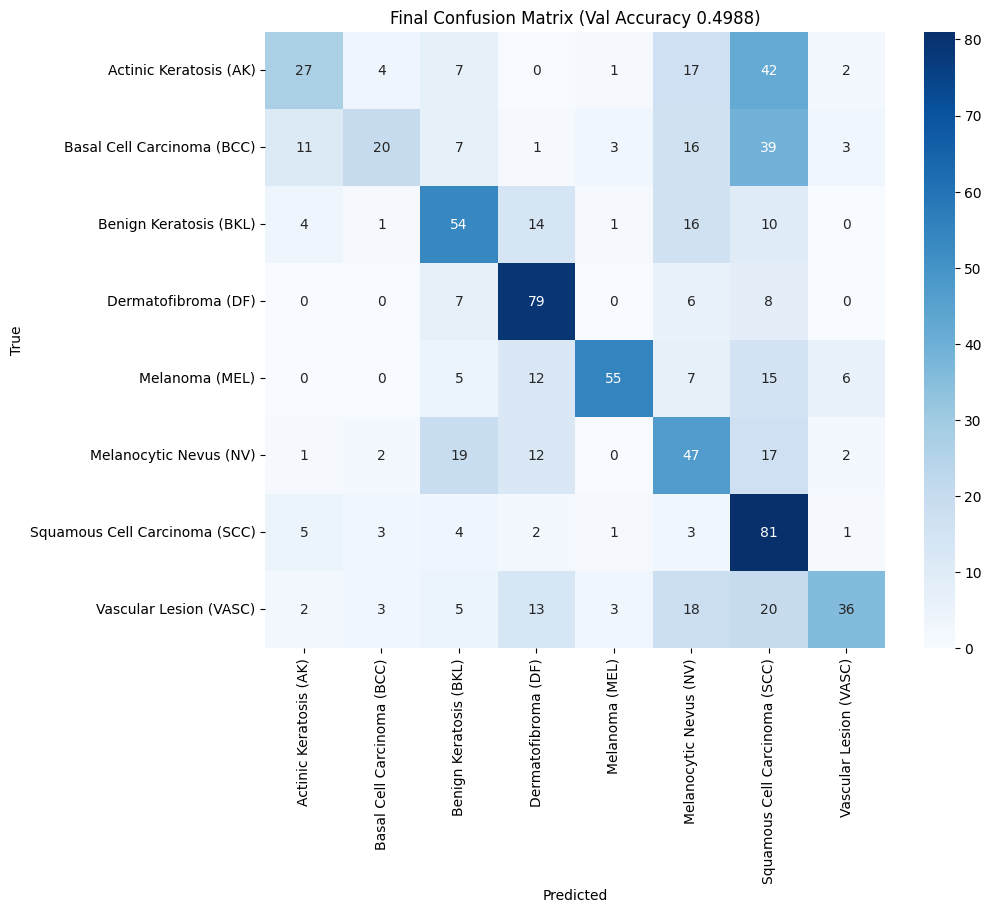

In [15]:
model = tf.keras.models.load_model("best_skin_model_fine_tune_1_1.keras")

# Evaluate
test_loss, test_acc = model.evaluate(val_dataset)
print(f"Final Val Accuracy: {test_acc:.4f}")

# Class name
class_names = [
    'Actinic Keratosis (AK)',
    'Basal Cell Carcinoma (BCC)',
    'Benign Keratosis (BKL)',
    'Dermatofibroma (DF)',
    'Melanoma (MEL)',
    'Melanocytic Nevus (NV)',
    'Squamous Cell Carcinoma (SCC)',
    'Vascular Lesion (VASC)'
]

# Classification report
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in val_dataset])

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')


print(classification_report(y_true, y_pred_classes, target_names=['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']))
print(f"ROC-AUC (One-vs-Rest): {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Final Confusion Matrix (Val Accuracy 0.4988)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## ROC-AUC

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


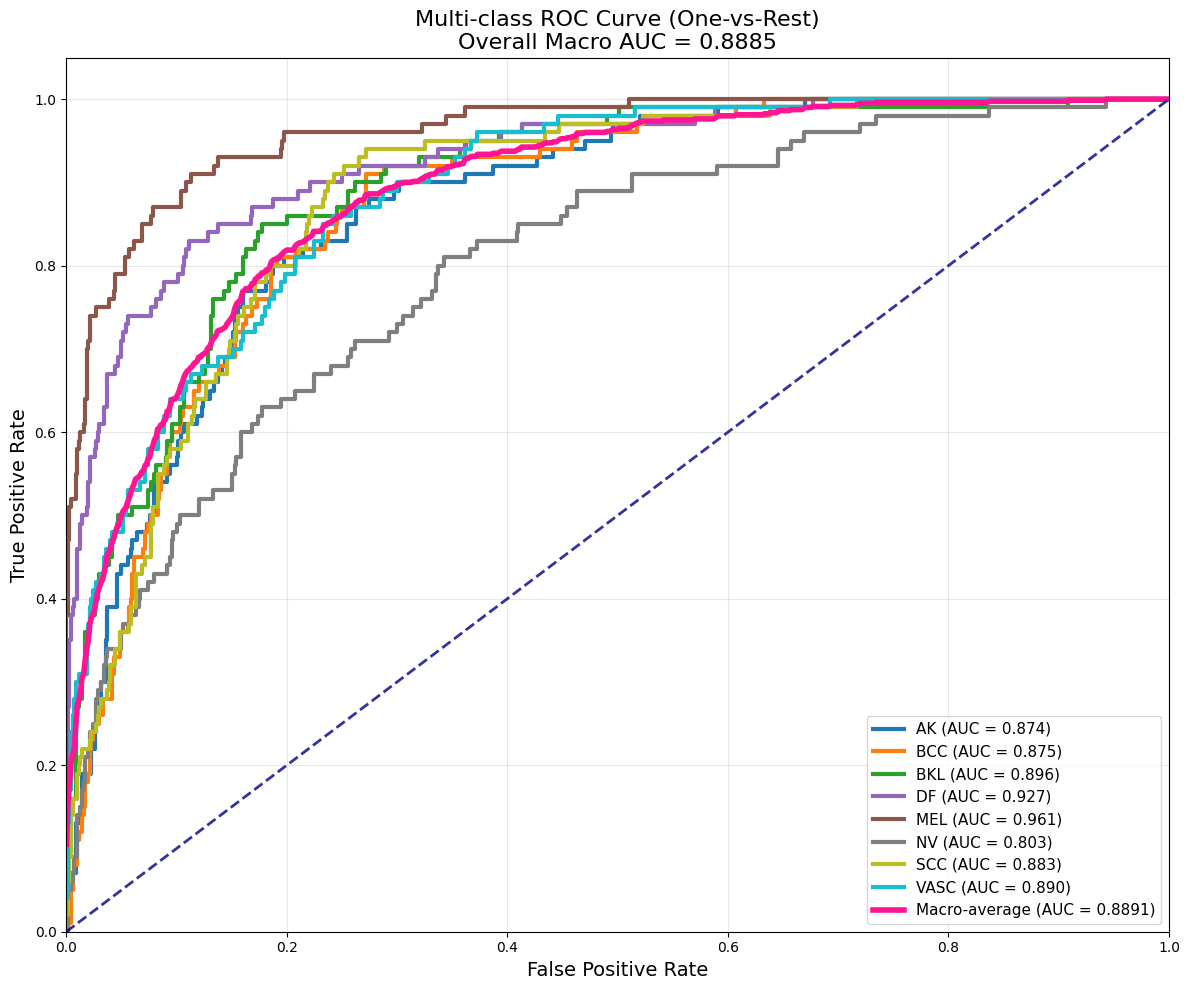

In [18]:
# get y_ture and y_score (probabilities)
y_true = np.concatenate([y for x, y in val_dataset]) 
y_score = model.predict(val_dataset) 

# Binarize labels for multi-class
n_classes = 8
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Calculate class ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



plt.figure(figsize=(12, 10))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))  #

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Macro-average
plt.plot(fpr["macro"], tpr["macro"], color='deeppink', linestyle='-', lw=4,  
         label=f'Macro-average (AUC = {roc_auc["macro"]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curve (One-vs-Rest)\nOverall Macro AUC = 0.8885', fontsize=16)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Fine-tune 2 (unfreeze 30)

In [10]:
# Adjust class-weight
class_weights = compute_class_weight('balanced', classes=np.unique(new_y_train_2), y=new_y_train_2)
class_weight_dict = dict(zip(np.unique(new_y_train_2), class_weights))

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [15]:
# Fine-tune
base_model.trainable = True 
for layer in base_model.layers[:-30]:   
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True


# load best performance model
model = tf.keras.models.load_model("best_skin_model_2.keras", compile=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_fine_tune = [
    EarlyStopping(patience=30, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=1, min_lr=1e-5),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model_fine_tune_2.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history_fine_tune = model.fit(
    train_dataset_2,
    validation_data=val_dataset,
    epochs=150,          
    callbacks=callbacks_fine_tune, 
    class_weight = class_weight_dict      
)

Epoch 1/150


2025-12-15 20:28:25.058889: I external/local_xla/xla/service/service.cc:163] XLA service 0x7b910c0025a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-15 20:28:25.058953: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-12-15 20:28:25.459886: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-15 20:28:26.977988: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
I0000 00:00:1765801718.298513     861 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2388/2388 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7189 - loss: 0.5575
Epoch 1: val_accuracy improved from None to 0.43750, saving model to best_skin_model_fine_tune_2.keras
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 95s 30ms/step - accuracy: 0.6643 - loss: 0.9200 - val_accuracy: 0.4375 - val_loss: 1.5990 - learning_rate: 0.0010
Epoch 2/150
2387/2388 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7195 - loss: 0.5587
Epoch 2: val_accuracy improved from 0.43750 to 0.44000, saving model to best_skin_model_fine_tune_2.keras
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - accuracy: 0.6686 - loss: 0.9079 - val_accuracy: 0.4400 - val_loss: 1.5834 - learning_rate: 0.0010
Epoch 3/150
2387/2388 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7111 - loss: 0.5647
Epoch 3: val_accuracy did not improve from 0.44000
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - accuracy: 0.6667 - loss: 0.9040 - val_accuracy: 0.4300 - val_loss: 1.6275 - learning_rate: 0.0010
Epoch 4/150
2387/2388 ━━━━━━━━━━━━━━━━━━━━ 0s 2

## Unfreeze 50

In [16]:
# Fine-tune
base_model.trainable = True 
for layer in base_model.layers[:-50]:   
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True


# load best performance model
model = tf.keras.models.load_model("best_skin_model_fine_tune_2.keras", compile=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_fine_tune = [
    EarlyStopping(patience=25, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=1, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model_fine_tune_2_1.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history_fine_tune = model.fit(
    train_dataset_2,
    validation_data=val_dataset,
    epochs=150,          
    callbacks=callbacks_fine_tune, 
    class_weight = class_weight_dict      
)

Epoch 1/150
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6731 - loss: 0.6957
Epoch 1: val_accuracy improved from None to 0.44125, saving model to best_skin_model_fine_tune_2_1.keras
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 87s 29ms/step - accuracy: 0.6681 - loss: 0.9328 - val_accuracy: 0.4412 - val_loss: 1.5732 - learning_rate: 1.0000e-04
Epoch 2/150
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6805 - loss: 0.6785
Epoch 2: val_accuracy improved from 0.44125 to 0.44500, saving model to best_skin_model_fine_tune_2_1.keras
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - accuracy: 0.6642 - loss: 0.9433 - val_accuracy: 0.4450 - val_loss: 1.5600 - learning_rate: 1.0000e-04
Epoch 3/150
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6779 - loss: 0.6783
Epoch 3: val_accuracy did not improve from 0.44500
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - accuracy: 0.6654 - loss: 0.9366 - val_accuracy: 0.4325 - val_loss: 1.6003 - learning_rate: 1.0000e-04
Epoch 4/150
2388/23

## Unfreeze 80

In [11]:
# Fine-tune
base_model.trainable = True 
for layer in base_model.layers[:-80]:   
    layer.trainable = False
for layer in base_model.layers[-80:]:
    layer.trainable = True


# load best performance model
model = tf.keras.models.load_model("best_skin_model_fine_tune_2_1.keras", compile=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_fine_tune = [
    EarlyStopping(patience=25, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=1, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model_fine_tune_2_2.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history_fine_tune = model.fit(
    train_dataset_2,
    validation_data=val_dataset,
    epochs=150,          
    callbacks=callbacks_fine_tune, 
    class_weight = class_weight_dict      
)

Epoch 1/150


2025-12-17 12:25:34.743857: I external/local_xla/xla/service/service.cc:163] XLA service 0x761c14092540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-17 12:25:34.743920: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-12-17 12:25:35.176767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-17 12:25:36.759072: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
I0000 00:00:1765945548.501416     936 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2388/2388 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7194 - loss: 0.6003
Epoch 1: val_accuracy improved from None to 0.44875, saving model to best_skin_model_fine_tune_2_2.keras
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 97s 31ms/step - accuracy: 0.6755 - loss: 0.9286 - val_accuracy: 0.4487 - val_loss: 1.5245 - learning_rate: 1.0000e-04
Epoch 2/150
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6840 - loss: 0.6725
Epoch 2: val_accuracy did not improve from 0.44875
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - accuracy: 0.6651 - loss: 0.9457 - val_accuracy: 0.4425 - val_loss: 1.5626 - learning_rate: 1.0000e-04
Epoch 3/150
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6860 - loss: 0.6735
Epoch 3: val_accuracy improved from 0.44875 to 0.45375, saving model to best_skin_model_fine_tune_2_2.keras
2388/2388 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - accuracy: 0.6665 - loss: 0.9440 - val_accuracy: 0.4538 - val_loss: 1.5320 - learning_rate: 1.0000e-04
Epoch 4/150
2388/2388 ━━━━━━━━━

## Performance

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4938 - loss: 1.3517
Final Val Accuracy: 0.4938
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
              precision    recall  f1-score   support

          AK       0.52      0.39      0.45       100
         BCC       0.47      0.27      0.34       100
         BKL       0.49      0.57      0.53       100
          DF       0.51      0.81      0.63       100
         MEL       0.90      0.60      0.72       100
          NV       0.37      0.41      0.39       100
         SCC       0.38      0.71      0.49       100
        VASC       0.73      0.19      0.30       100

    accuracy                           0.49       800
   macro avg       0.54      0.49      0.48       800
weighted avg       0.54      0.49      0.48       800

ROC-AUC (One-vs-Rest): 0.8861


2025-12-17 14:29:17.256566: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


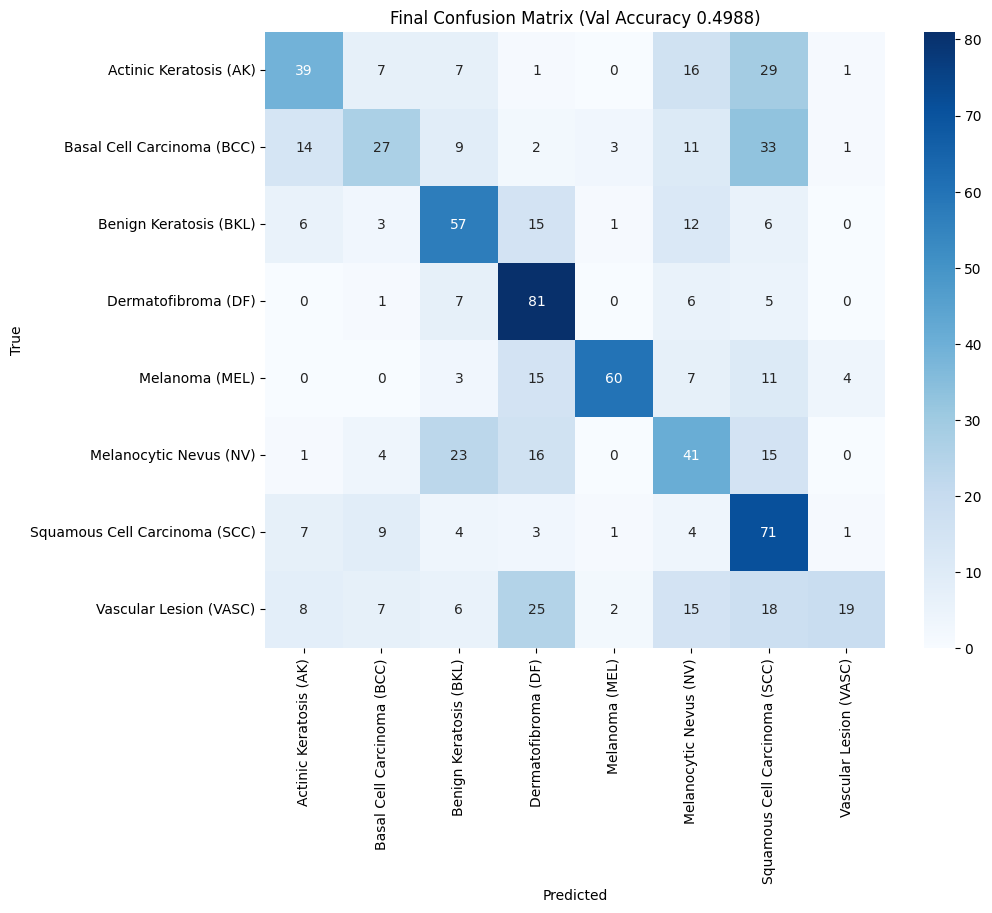

In [12]:
model = tf.keras.models.load_model("best_skin_model_fine_tune_2_2.keras")

# Evaluate
test_loss, test_acc = model.evaluate(val_dataset)
print(f"Final Val Accuracy: {test_acc:.4f}")

# Class name
class_names = [
    'Actinic Keratosis (AK)',
    'Basal Cell Carcinoma (BCC)',
    'Benign Keratosis (BKL)',
    'Dermatofibroma (DF)',
    'Melanoma (MEL)',
    'Melanocytic Nevus (NV)',
    'Squamous Cell Carcinoma (SCC)',
    'Vascular Lesion (VASC)'
]

# Classification report
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in val_dataset])

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')


print(classification_report(y_true, y_pred_classes, target_names=['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']))
print(f"ROC-AUC (One-vs-Rest): {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Final Confusion Matrix (Val Accuracy 0.4988)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## ROC-AUC

 7/50 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

2025-12-17 14:30:13.863174: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


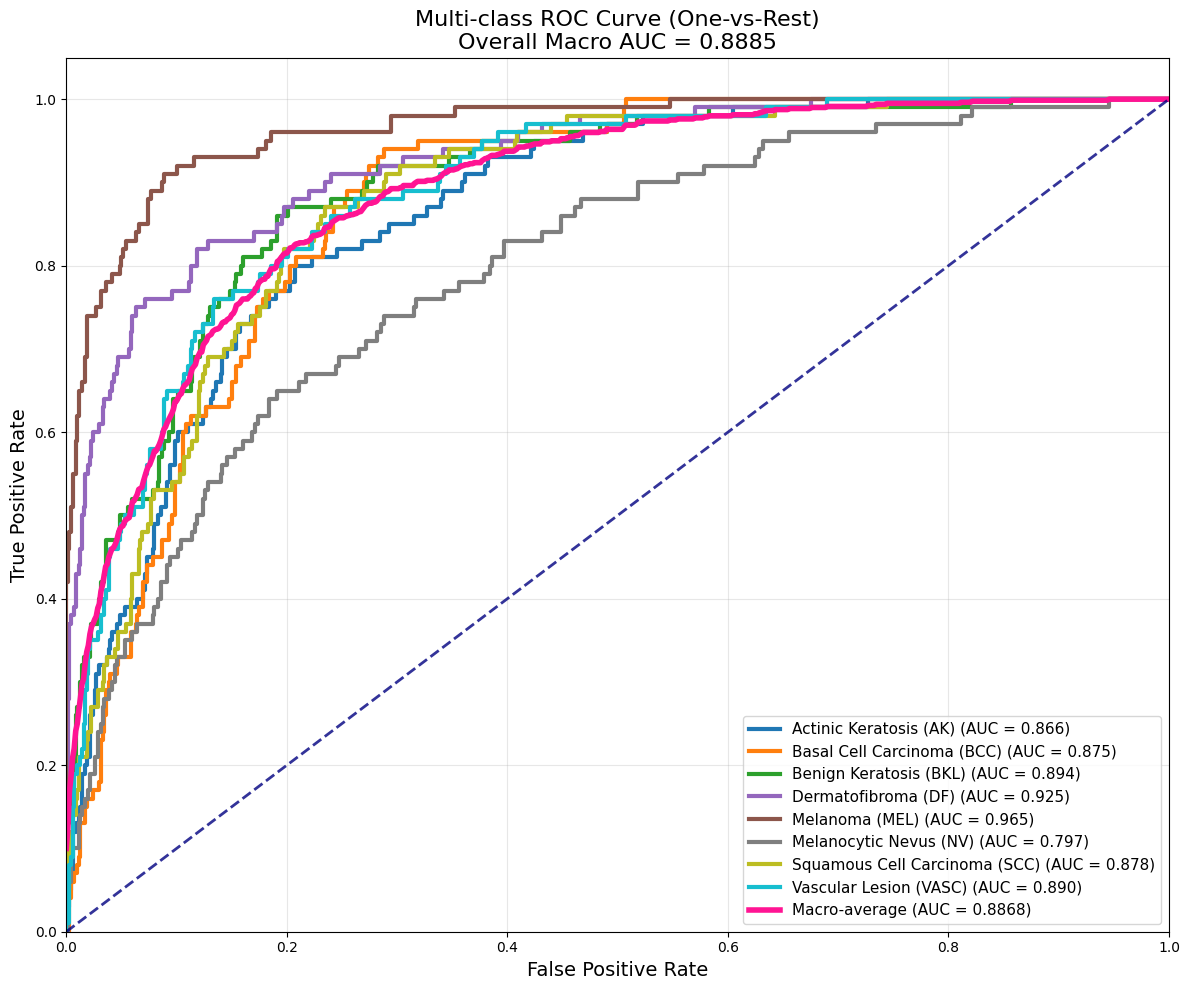

In [13]:
# get y_ture and y_score (probabilities)
y_true = np.concatenate([y for x, y in val_dataset]) 
y_score = model.predict(val_dataset) 

# Binarize labels for multi-class
n_classes = 8
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Calculate class ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



plt.figure(figsize=(12, 10))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))  #

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Macro-average
plt.plot(fpr["macro"], tpr["macro"], color='deeppink', linestyle='-', lw=4,  
         label=f'Macro-average (AUC = {roc_auc["macro"]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curve (One-vs-Rest)\nOverall Macro AUC = 0.8885', fontsize=16)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Result

## The best model is best_skin_model_fine_tune_1_1.keras with val_accuracy = 0.4988, loss = 1.3430, AUC = 0.8891 ##